In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from official_ema_functions import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics

In [2]:
def convert_stress(level):
    """
    converts input stress level from the scale above into a more usable scale with 1 being feeling great 
    and 5 being stressed out.
    """
    # little stress = 3/5 stressed
    if level == 1: 
        return 3
    # definitely stressed = 4/5
    if level == 2:
        return 4
    # stressed out = 5/5
    if level == 3:
        return 5
    # feeling good = 2/5
    if level == 4: 
        return 2
    # feeling great = 1/5 
    if level == 5:
        return 1
    else:
        return 0

In [3]:
def convert_PAM(level):
    """
    assigns PAM picture_idx levels to four ranges (four quadrants):
    Quadrant 1: negative valence and low arousal; Quadrant 2: negative valence and high arousal; 
    Quadrant 3: positive valence and low arousal; Quadrant 4: positive valence and high arousal
    """
    quadrant_1 = list(range(1,5))
    quadrant_2 = list(range(5,9))
    quadrant_3 = list(range(9,13))
    quadrant_4 = list(range(13,17))
    
    if level in quadrant_1:
        return 1
    if level in quadrant_2: 
        return 2
    if level in quadrant_3: 
        return 3
    if level in quadrant_4: 
        return 4

In [43]:
def location_variance(gps_df):
    """
    returns the location variance of the gps dataframe, which is log(variance of latitiude squared plus variance of 
    longitude squared)
    """
    num =  gps_df['lon'].var() + gps_df['lat'].var()
    return log(num)

In [44]:
def process_stress_ema_remove_null(uid, ema_name, desired_column): 
    """
    input: uid for which we want to process the stress EMA
    """
    #ema = pd.read_json('dataset/dataset/EMA/response/{}/{}_{}.json'.format(ema_name, ema_name, uid))
    ema = pd.read_json('dataset/dataset/EMA/response/'+ ema_name + '/' + ema_name + '_' + uid + '.json')

    try: 
        ema[desired_column] = ema[desired_column].where(np.isfinite, ema.null)
    except: 
        pass

        
    ema[desired_column] = pd.to_numeric(ema[desired_column], errors='coerce')
    
    ema = ema[['resp_time', desired_column]]
    ema = ema.dropna()
    
    if ema_name == 'stress': 
        ema['level'] = ema['level'].apply(convert_stress)
    if ema_name == 'PAM':
        ema['picture_idx'] = ema['picture_idx'].apply(convert_PAM)
    
    return ema

In [45]:
process_stress_ema_remove_null('u07', 'PAM', 'picture_idx')

,resp_time,picture_idx
0,2013-03-30 20:27:43,4
1,2013-03-24 10:48:05,2
2,2013-03-24 10:48:09,3
3,2013-03-24 09:56:55,2
4,2013-04-02 12:21:39,4
...,...,...
142,2013-04-26 02:27:06,3
143,2013-04-29 22:00:39,4
144,2013-04-28 22:22:40,4
145,2013-04-29 08:10:30,4


In [46]:
def num_changes(wifi_locations): 
    changes = -1
    previous = None
    
    for location in wifi_locations['location'].values: 
        if location != previous:
            changes += 1
            previous = location
        else: 
            continue
            
    return changes

In [47]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [48]:
def load_activity(uid): 
    # load activity data
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['time'] = pd.to_datetime(activity['timestamp'], unit = 's') 
    activity['day'] = activity['time'].dt.dayofyear
    activity = activity[activity[' activity inference'] != 3]
    return activity

def load_conversation(uid): 
    # load conversation data
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    return conversation

def load_darkness(uid): 
    # load darkness data
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['duration'] = darkness['end'] - darkness['start']
    return darkness

def load_bluetooth(uid):
    # load bluetooth data
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['time'] = pd.to_datetime(bluetooth['time'], unit = 's')
    bluetooth['day'] = bluetooth['time'].dt.dayofyear
    return bluetooth

def load_gps(uid):
    # gps data 
    gps = pd.read_csv('dataset/dataset/sensing/gps/gps_' + uid + '.csv')
    # data is out of order, this will reformat it. 
    gps.reset_index(inplace = True)
    gps.columns = ('timestamp', 'provider', 'network_type', 'accuracy', 'lat',
                   'lon', 'altitude', 'bearing' ,'speed', 'travelstate', 'null')
    gps = gps.drop("null", 1)
    gps['time'] = pd.to_datetime(gps['timestamp'], unit = 's')
    gps['day'] = gps['time'].dt.dayofyear
    return gps

def load_wifi_locations(uid): 
    # wifi locations data
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['time'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's')
    wifi_locations['day'] = wifi_locations['time'].dt.dayofyear
    return wifi_locations

def load_sms(uid):
    sms = pd.read_csv('dataset/dataset/sms/sms_' + uid + '.csv')
    sms['time'] = pd.to_datetime(sms['timestamp'], unit='s')
    sms['day'] = sms['time'].dt.dayofyear
    return sms

def load_phone_lock(uid):
    phone_lock = pd.read_csv('dataset/dataset/sensing/phonelock/phonelock_' + uid + '.csv')
    phone_lock = phone_lock.rename(columns={'start': 'start_timestamp', 'end': 'end_timestamp'})
    phone_lock['lock dur'] = phone_lock['end_timestamp'] - phone_lock['start_timestamp']
    phone_lock['day'] = pd.to_datetime(phone_lock['start_timestamp'], unit='s').dt.dayofyear
    phone_lock['start_day'] = phone_lock['day']
    phone_lock['end_day'] = pd.to_datetime(phone_lock['end_timestamp'], unit='s').dt.dayofyear
    return phone_lock

def load_app_usage(uid):
    app_usage = pd.read_csv('dataset/dataset/app_usage/running_app_' + uid + '.csv')
    app_usage['time'] = pd.to_datetime(app_usage['timestamp'], unit='s')
    app_usage['day'] = app_usage['time'].dt.dayofyear
    return app_usage

In [49]:
def conversation_in_range(time_interval, convo_df, start_name, end_name): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        convo_df -- a dataframe containing start and end timestamps for a duration measurement 
            (so this function can be used for darkness as well as conversation)
        start_name -- name of the column indicating the start timestamp
        end_name -- name of the column indicating the end timestamp. 
    outputs: 
        the total conversation duration in the time interval.
        
    Note -- I initially named this function for activity so the variable names reflect that, but it can be applied to
    multiple sensor data. 
    
    This function is is similar to the activity in range but applies to dataframes contianing durations so the approach is
    slightly different.  
    """
    # again, unpack interval. 
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # look at relevant days 
    if start_day == end_day: 
        conv = convo_df[convo_df['day'] == start_day]
    else: 
        conv = convo_df[convo_df['day'] == start_day].append(convo_df[convo_df['day'] == end_day])
  
    # turn the conversations into intervals. If none exist, the duration is 0. 
    #try:
    conv['interval'] = list(zip(pd.to_datetime(conv[start_name], unit = 's'), 
                                    pd.to_datetime(conv[end_name], unit = 's')))
    #except:
        #return 0

    
    # this function returns the duration of conversation inside the desired interval for each time interval. 
    conv['desired duration'] = conv['interval'].apply(lambda x: conv_range(start, end, x))
    conv = conv.dropna()
    
    # return the sum of all desired intervals. 

    return conv['desired duration'].sum()

In [50]:
def conv_range(start, end, conv_interval): 
    """
    returns the amount of seconds of conversation are in the interval (start, end)
    """
    conv_start = conv_interval[0]
    conv_end = conv_interval[1]
    
    if conv_end < start: 
        return np.nan
    
    elif conv_start > end:
        return np.nan
    
    elif conv_start >= start and conv_end >= end:
        return end - conv_start 
    
    elif conv_start <= start and conv_end <= end:
        return conv_end - start
    
    elif conv_start >= start and conv_end <= end:
        return conv_end - conv_start
    
    elif conv_start <= start and conv_end >= end:
        return end - start
    
def convert_timedeltas(x): 
    """
    converts timedeltas to seconds, leaves any numbers
    """
    try:
        return x.seconds
    except:
        return x 

In [51]:
def activity_in_range(time_interval, activity_df, func = 'act'): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        activity_df -- dataframe for a single user. 
    outputs: 
        the mean activity inference in the time interval.
        
    Note: the activity dataframe and variable names imply 
    """
    
    # unpack the values from the time interval
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # only look at relevant days to say runtime
    if start_day == end_day: 
        activity = activity_df[activity_df['day'] == start_day]
    else: 
        activity = activity_df[activity_df['day'] == start_day].append(activity_df[activity_df['day'] == end_day])
        
    # this try except loop takes care of the case where the activity data is an empty dataframe, so we return Nan 
    try: 
        ### these cases are different for different func inputs so this function can be extensible. 
        
        # in this case, we are looking at activity and taking the mean
        if func == 'act':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].sum()
        elif func == 'all_act': 
            print(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values)
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values
        # in this case, we are looking at bluetooth and take the count
        elif func == 'count':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))].shape[0]
        elif func == 'cnt':
            return np.unique(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))]).shape[0]
        # in this case we apply the location variance function 
        elif func == 'location variance': 
            return location_variance(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
        elif func == 'location changes': 
            return num_changes(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
    except:
        # if we find none in count, we return 0. If not, there is no data/average from there so return Nan. 
        if func == 'count': 
            return 0
        return np.nan

In [52]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_df

In [53]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis_walking(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity[activity[' activity inference'] !=2]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_df

In [54]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis_running(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity[activity[' activity inference'] !=1]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    
    return activity_dur_df

In [55]:
def deadlines_processing():
    data = pd.read_csv('dataset/dataset/education/deadlines.csv')
    data = data.dropna(axis=1, how='all')
    data = data.T
    old_names = list(data.columns)
    new_names = data.iloc[0]
    data.rename(columns=dict(zip(old_names, new_names)), inplace=True)
    data = data.drop(['uid'])
    data['doy'] = pd.to_datetime(data.index)
    data['doy'] = data['doy'].dt.dayofyear
    return data

In [56]:
def only_academic_locations(uid):
    class_info = pd.read_json('dataset/dataset/education/class_info.json')
    all_locations = list(class_info.iloc[0,:])
    
    def unique_locations(data):
        unique_locations = []
        for i in list1:
            if i not in unique_locations:
                unique_locations.append(i)
        return list(unique_locations)
    locations = unique(all_locations)
    
    def location(list2):
        class_loc = []
        for i in list2:
            class_loc.append('in[' + str(i) + ']')
        return class_loc
    class_locations = location(locations)
    
    wifi_data = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    
    def only_class_locations(data, locations):
        df_with_only_class_locations = data[data.time.isin(locations)] 
        df_with_only_class_locations['start_time'] = df_with_only_class_locations.index
        df_with_only_class_locations['start time'] = pd.to_datetime(df_with_only_class_locations['start_time'], unit='s')
        df_with_only_class_locations['day'] = df_with_only_class_locations['start time'].dt.dayofyear
        df_with_only_class_locations['location'] = df_with_only_class_locations['time']
        df_with_only_class_locations = df_with_only_class_locations.reset_index()
        return df_with_only_class_locations
    wifi_data = only_class_locations(wifi_data, class_locations)
    
    def shift_counter(data):
        shift_num = 0
        list_shift_num = []
        for i in range(0, len(data)):
            try: 
                if data.location[i] == data.location[i+1] and data.day[i] == data.day[i+1]:
                    shift_num += 1
                else:
                    list_shift_num.append(shift_num)
                    shift_num = 0
            except:
                list_shift_num.append(shift_num)
                shift_num = 0
        return list_shift_num
    list_shift = shift_counter(wifi_data)
    
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    list_shifts = shifts_only(list_shift)
    
    def shift_counter_id(data):
        shift_num = 0
        list_shift_num = []
        #list_id = []
        list_time = []
        list_location = []
        for i in range(0, len(data)):
        #if data.location[i] == data.location[i+1]:
            try: 
                if data.location[i] == data.location[i+1] and data.day[i] == data.day[i+1]:
            #data.index[i] == (data.index[i+1] - 1)
                    shift_num += 1
                    #uid = data.uid[i]
                    time = data.start_time[i]
                    location = data.location[i]
                else:
                    list_shift_num.append(shift_num)
                    shift_num = 0
                    #list_id.append(uid)
                    list_time.append(time)
                    list_location.append(location)
            except:
                list_shift_num.append(shift_num)
                shift_num = 0
                #list_id.append(uid)
                list_time.append(time)
                list_location.append(location)
        df = pd.DataFrame({'Shift Num': list_shift_num, 'time': list_time, 'location': list_location}) #'time': list_time, 'location': list_location})
        return df

#This dataframe contains the shift numbers and their associated times, locations and user ids
    dataframe = shift_counter_id(wifi_data)
    
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before = get_sums(list_shifts)

    def time_delta(location_data, shift_data, list_shift_num, sums_before):
        time_deltas = []
        location = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(location_data['start_time'][list_shift_num[i]] - location_data['start_time'][0])
                #uid.append(data.uid[i])
                start_time.append(shift_data.time[i])
                location.append(shift_data.location[i])
            elif i != 0:
                time_deltas.append(location_data['start_time'][list_shift_num[i]+i+sums_before[i]] - location_data['start_time'][sums_before[i]+i])
                #uid.append(data.uid[i])
                start_time.append(shift_data.time[i])
                location.append(shift_data.location[i])
            df1 = pd.DataFrame({'Time Delta': time_deltas, 'start_time': start_time, 'location': location})
            df1['end_time'] = df1['Time Delta'] + df1['start_time']
            df1['start_day'] = pd.to_datetime(df1['start_time'], unit='s').dt.dayofyear
            df1['day'] = df1['start_day']
            df1['end_day'] = pd.to_datetime(df1['end_time'], unit='s').dt.dayofyear
        return df1

#The function returns the new dataframe.
    time_spent_academic_locations = time_delta(wifi_data, dataframe, list_shifts, list_sums_before)
    
    return time_spent_academic_locations 

In [4]:
deadlines_data = deadlines_processing()

In [58]:
x=load_bluetooth('u59')
len(x.class_id.unique())

45

In [59]:
from sklearn.preprocessing import OneHotEncoder
def ema_intervals_data(uid, window, ema_name, desired_column): 
    """
    inputs: uid -- user id 
            window -- the frame of time (in hours) of how long the interval of sensor collection around each EMA should be. 
    
    Finds desired sensor data within that window of time before and after the EMA. 
    
    Returns: a dataframe containing stress level and desired feature information for each stress response. If the
    dataframe has less than 50 elements returns none (we assume there isn't enough data with less than 50 elements). 
    """
    data = process_stress_ema_remove_null(uid, ema_name, desired_column)
    
    # define the window of time we want to look at for each stress answer. 
    data['start_time'] = data['resp_time'] - pd.to_timedelta(window, unit = 'h')
    data['end_time'] = data['resp_time'] + pd.to_timedelta(window, unit = 'h')
    
    # this will reduce runtime by only looking at sensor data from that day then applying our interval function to it. 
    data['start_day'] = data['start_time'].dt.dayofyear
    data['end_day'] = data['end_time'].dt.dayofyear
    data['doy'] = data['resp_time'].dt.dayofyear
    
    data['dow'] = data['resp_time'].dt.dayofweek
    data = data.join(pd.get_dummies(data['dow']))
    data = data.rename(columns={0: 'Monday', 
                                1: 'Tuesday', 
                                2: 'Wednesday', 
                                3: 'Thursday', 
                                4: 'Friday',
                                5: 'Saturday',
                                6: 'Sunday'})
    
    
    # the time interval is just a tuple of (start time, end time)
    # in the future, we will apply functions to the interval using other dataframes to return desired columns inside
    # the interval
    data['interval'] = tuple(zip(data['start_time'], data['end_time'], data['start_day'], data['end_day']))

    # load activity data
    activity = activity_analysis(uid)
    data['activity dur'] = data['interval'].apply(lambda x: conversation_in_range(x, activity, 
                                                                           'start_time', 'end_time'))
    data['activity dur'] = data['activity dur'].apply(convert_timedeltas)
    
    walking = activity_analysis_walking(uid)
    data['walking dur'] = data['interval'].apply(lambda x: conversation_in_range(x, walking, 
                                                                           'start_time', 'end_time'))
    data['walking dur'] = data['walking dur'].apply(convert_timedeltas)
    
    running = activity_analysis_running(uid)
    data['running dur'] = data['interval'].apply(lambda x: conversation_in_range(x, running, 
                                                                           'start_time', 'end_time'))
    data['running dur'] = data['running dur'].apply(convert_timedeltas)
    
    academic_locations = only_academic_locations(uid)
    data['academic location dur'] = data['interval'].apply(lambda x: conversation_in_range(x, academic_locations, 
                                                                           'start_time', 'end_time'))
    data['academic location dur'] = data['academic location dur'].apply(convert_timedeltas)
    
    # this will return the total conversation duration for each interval
    conversation = load_conversation(uid)
    data['conversation dur'] = data['interval'].apply(lambda x: conversation_in_range(x, conversation, 
                                                                           'start_timestamp', ' end_timestamp'))
    data['conversation dur'] = data['conversation dur'].apply(convert_timedeltas)
    
    # find the total darkness duration for each interval
    darkness = load_darkness(uid)
    data['darkness dur'] = data['interval'].apply(lambda x: conversation_in_range(x, darkness, 'start', 'end'))
    data['darkness dur'] = data['darkness dur'].apply(convert_timedeltas)
    

    # find the number of bluetooth colocations in each interval
    bluetooth = load_bluetooth(uid)
    #bluetooth = bluetooth[bluetooth['level'] >= -70]
    data['bluetooth colocations'] = data['interval'].apply(lambda x: activity_in_range(x, bluetooth, 'count'))
    
    # find the number of unique bluetooth colocations in each interval
    #data['num unique bluetooth colocations'] = data['interval'].apply(lambda x: activity_in_range(x, bluetooth, 'location changes'))
    
    # find the location variance in each stress interval. 
    gps = load_gps(uid)
    data['location variance'] = data['interval'].apply(lambda x: activity_in_range(x, gps, 'location variance'))
    
    # wifi locations
    wifi_locations = load_wifi_locations(uid)
    data['location changes'] = data['interval'].apply(lambda x: activity_in_range(x, wifi_locations, 'location changes'))
    
    sms = load_sms(uid)
    data['sms'] = data['interval'].apply(lambda x: activity_in_range(x, sms, 'count'))
    
    phone_lock = load_phone_lock(uid)
 
    data['phone lock dur'] = data['interval'].apply(lambda x: conversation_in_range(x, phone_lock, 
                                                                           'start_timestamp', 'end_timestamp'))
    data['phone lock dur'] = data['phone lock dur'].apply(convert_timedeltas)

    
    app_usage = load_app_usage(uid)
    data['app usage'] = data['interval'].apply(lambda x: activity_in_range(x, app_usage, 'count'))
    
    #load deadlines data.
    deadlines = deadlines_processing()
    #deadlines = deadlines[deadlines['doy' == data.start_day]]
    deadlines = deadlines[[uid, 'doy']]
    data = pd.merge(data, deadlines, on='doy', how='inner')
    data = data.rename(columns={uid: 'deadlines'})
    
    data['uid'] = uid
    
    
    # drop Nan values
    data = data.dropna()
    
    features = list(data.columns)
    targets = features.pop(1)
    
     #only use these features if we have over 50 datapoints
    if data.shape[0] < 20: 
        return None
    
    
    # return relevant columns. 
    return data

In [60]:
#n = ema_intervals_data('u59', 10, 'PAM', 'picture_idx')

In [61]:
#n.head()

In [62]:
#add in number of classes??
#gps vs. network
#n.columns

In [63]:
#for i in (range(len(uids))):
#    if i == 0:
        #for j in [2,4,6,8,10]:
#        uid = uids[i]
 #       window = 6
  #      #feature_names = feature_names_
   #     user_score_df = ema_intervals_data(uid, window, 'PAM', 'picture_idx')
    #    #user_score_df['uid'] = uid
     #   
    #else:
     #   try:
      #      #for j in [2,4,6,8,10]:
       #     uid = uids[i]
        #    window = 6
         #   #feature_names = feature_names_
          #  #df = ema_intervals_data(uid, window, 'PAM', 'picture_idx')
           # #df['uid'] = uid
           # user_score_df = user_score_df.append(ema_intervals_data(uid, window, 'PAM', 'picture_idx'))
            #user_score_df['uid'] = uid
        #except: 
         #   pass
        
#user_score_df.head()

In [64]:
#user_score_df.to_csv('user_windows_final.csv',index=False)

In [5]:
n = pd.read_csv('user_windows_final.csv')
n = n[n.uid == 'u59']

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, TimeSeriesSplit

def random_forest_importance(features, target, features_names, plot, cv): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
           cv: boolean, if True, return average cross validation score instead of feature importances. 
    given input features and targets (labels), a random forest model is created to find the importance of each feature to 
    the target. Plots these outcomes. 
    """
    # just from some guess and check, it seems that using 500 estimators greatly reduces the random element of the 
    # classifier
    model = RandomForestClassifier(max_depth = 10, n_estimators = 500)
    model.fit(features, target)
    

    if plot is True: 
        # to determine if the model is better than random chance(i.e. our important features are actually important),
        # we can check with a cross validation score.
        #print('average cross validation score: {:.2f}'.format(cross_val_score(RandomForestClassifier(n_estimators = 500),
        #                                                                      features, target, cv = 3).mean()))
        
        n_features = features.shape[1]
        plot_feature_importance(n_features, features_names, model.feature_importances_)
        
    if cv is True: 
        
        tscv = TimeSeriesSplit(n_splits = 5)
        avg_score = 0
        
        for train_index, test_index in tscv.split(features): 
            #print(train_index)
            #print(test_index)
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = target[train_index], target[test_index]
            
            forest = RandomForestClassifier(n_estimators = 500)
            forest.fit(X_train, y_train)
            score = forest.score(X_test, y_test)
            #print(train_index, test_index, score)
            avg_score += score/5
            #print(avg_score)
        
        return avg_score
    
        
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5)
        
    y_pred = model.predict(X_test)
    
    x = print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    
    return model.feature_importances_


In [116]:
feature_names_ = ['activity dur',
       'walking dur', 'running dur', 'academic location dur',
       'conversation dur', 'darkness dur', 'bluetooth colocations',
       'location variance', 'location changes', 'sms', 'phone lock dur',
       'app usage', 'deadlines']


In [8]:
feature_names_2 = ['activity dur', 'conversation dur', 'darkness dur','bluetooth colocations', 
                  'location variance', 'location changes', 'deadlines']


In [10]:
random_forest_importance(n[feature_names_].values, n[['picture_idx']].values, feature_names_, False, False)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy: 0.9808612440191388
Accuracy: 0.9808612440191388


array([0.07575584, 0.07612872, 0.07389028, 0.07860307, 0.09386705,
       0.08881436, 0.08073481, 0.09244703, 0.07782059, 0.06585557,
       0.08011305, 0.09091558, 0.02505406])

In [9]:
def plot_feature_importance(n_features, features_names, feature_importance): 
    """
    input: n_features: number of features
           features_names: names of features
           feature_importance: the importance of each feature
    makes a bar plot showing the importance of each feature. 
    """
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')

In [11]:
from sklearn.utils import shuffle
def find_cv_scores(uid, window, ema, desired_column, data = None): 
    """
    inputs: uid -- user id
            window -- timeframe to examine
            plot -- if true, plots results
            cv -- if true, returns cross validation scores from stress prediction. 
            
    Finds the intervals of stress around the ema response within the window, predicts stress with those sensor data. 
    returns the feature importance of that stress prediction along with the feature names. 
    """
    
    # load intervals
    if data is None: 
        data = ema_intervals_data(uid, window, ema, desired_column)
    #data = ema_intervals_data(uid, window, ema, desired_column)
            
    feature_names = feature_names_
    
    features = data[feature_names].values
    
    target = data[desired_column].values
    
    #features, target = shuffle(features, target, random_state=0)
    
    #feat_import = perm_importance(features, target, feature_names, plot) 
    feat_import = random_forest_importance(features, target, feature_names, plot=False, cv=True)
    
    return feat_import #feature_names    

In [12]:
#find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)

In [13]:
def average_cv_scores(uid, window, ema, desired_column, data = None):
    cvs = []
    uid = []
    for i in range(0,10):
        cvs.append(find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None))
        uid.append(uid)
    df = pd.DataFrame({'cv': cvs, 'uid': uid})
    return df

In [14]:
def func():
    '''
    x_1 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_2 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_3 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_4 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_5 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_6 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_7 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_8 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_9 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_10 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)

    x_list = [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10]
    x_avg = (sum(x_list))/(len(x_list))
    x_avg
    '''
    return x_avg

In [15]:
from sklearn.model_selection import RandomizedSearchCV
def forest_gridsearch(features, target): 
    """
    adapted from 
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    performs a random parameter search on the random forest model and returns the best parameters and best score. 
    """
    # Number of trees in random forest
    n_estimators = [x*100 for x in range(1, 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [x*10 for x in range(1, 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(features, target)
    
    return rf_random.best_params_, rf_random.best_score_

In [16]:
def tscvscore(features, target, model, n_splits): 
    tscv = TimeSeriesSplit(n_splits = 5)
    avg_score = 0
        
    for train_index, test_index in tscv.split(features): 
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
            
       
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        #print("train indices: {}, test indices: {}, score: {:.2f}".format(train_index, test_index, score))
        #print("predictions: {}, actual: {}".format(model.predict(X_test), target[test_index]))
        avg_score += score/5
            
    return avg_score

In [17]:
def uid_list(ema_name):
    ema_files = glob.glob('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name + '_*.json')
    uid_start = len('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name + '_')
    deadlines_uid = list(deadlines_data.columns)
    deadlines_uid = deadlines_uid[:-1]
    uid_list = []
    for file in ema_files:
        uid = file[uid_start:uid_start+3]
    
        if uid == 'u24':
            #emas = pd.read_json(file)
            uid_list.append(uid)
            continue
        
        uid_list.append(uid)
    
    uid_list = [i for i in deadlines_uid if i in uid_list]
    return uid_list

In [18]:
uids = uid_list("PAM")

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

def validate_user(uid, window, ema_name, desired_column, feature_names):
    
    data = ema_intervals_data(uid, window, ema_name, desired_column)
    features = data[feature_names].values
    target = data[desired_column].values
    
    extra_trees = ExtraTreesClassifier()
    random_forest = RandomForestClassifier()
    
    et_scores = []
    rf_scores = []
    
   
    for i in range(10): 
    
        et_scores.append(tscvscore(features, target, extra_trees, 5))
        rf_scores.append(tscvscore(features, target, random_forest, 5))
                         
    cor_et_scores = []
    cor_rf_scores = []
    
    for i in range(10): 
        
        np.random.shuffle(target)
    
        cor_et_scores.append(tscvscore(features, target, extra_trees, 5))
        cor_rf_scores.append(tscvscore(features, target, random_forest, 5))

    
    
    return pd.DataFrame({'et score': et_scores, 
                         'rf score': rf_scores, 
                         'corrupted et score': cor_et_scores, 
                         'corrupted rf score': cor_rf_scores, 
                         'uid': uid, 
                         'window': window})

In [20]:
def validate_user_v2(uid, window, ema_name, desired_column, feature_names):
   
    data = ema_intervals_data(uid, window, ema_name, desired_column)
    features = data[feature_names].values
    target = data[desired_column].values
    
    extra_trees = ExtraTreesClassifier()
    random_forest = RandomForestClassifier()
    
    et_scores = []
    rf_scores = []
    
   
    for i in range(10): 
    
        et_scores.append(tscvscore(features, target, extra_trees, 5))
        rf_scores.append(tscvscore(features, target, random_forest, 5))
                         
    cor_et_scores = []
    cor_rf_scores = []
    
    for i in range(10): 
        
        np.random.shuffle(target)
    
        cor_et_scores.append(tscvscore(features, target, extra_trees, 5))
        cor_rf_scores.append(tscvscore(features, target, random_forest, 5))

    scores_df = pd.DataFrame({'et score': et_scores, 
                              'rf score': rf_scores, 
                              'corrupted et score': cor_et_scores, 
                              'corrupted rf score': cor_rf_scores, 
                              'uid': uid, 
                              'window': window})
    
    rf_p_value = scipy.stats.ttest_ind(scores_df['rf score'], scores_df['corrupted rf score'])[1]
    et_p_value = scipy.stats.ttest_ind(scores_df['et score'], scores_df['corrupted et score'])[1]
    
    if rf_p_value >= et_p_value: 
        return rf_p_value/2, scores_df[['rf score', 'corrupted rf score', 'uid', 'window']], 'rf'
    else: 
        return et_p_value/2, scores_df[['et score', 'corrupted et score', 'uid', 'window']], 'et'

In [21]:
def get_all_scores(window, ema_name, desired_column, feature_names):
    uids = uid_list(ema_name)
    uids.remove('u09')
    uids.remove('u13')
    user_score_df = pd.DataFrame()
    
    for i in range(len(uids)):
        
        if i == 0:
            uid = uids[i]
            window = window
            ema_name = ema_name
            desired_column = desired_column
            feature_names = feature_names
            user_score_df = validate_user(uid, window, ema_name, desired_column, ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines'])
    
        else:
            try:
                uid = uids[i]
                window = window
                ema_name = ema_name
                desired_column = desired_column
                feature_names = feature_names
                user_score_df = user_score_df.append(validate_user(uid, window, ema_name, desired_column, ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']))
            except ValueError: 
                pass
    return user_score_df

In [22]:
def get_all_scores_v2(window, ema_name, desired_column, feature_names):
    uids = uid_list(ema_name)
    uids.remove('u09')
    uids.remove('u13')
    user_score_df = pd.DataFrame()
    results_df = pd.DataFrame()
    windows = [2,4,6,8,10]
    
    for i in range(len(uids)):
        
        if i == 0:
            for j in windows:
                uid = uids[i]
                window = j
                ema_name = ema_name
                desired_column = desired_column
                feature_names = feature_names
                p, scores_df, best_model = validate_user_v2(uid, window, ema_name, desired_column, features)
                scores_df['diff'] = scores_df['{} score'.format(best_model)] - scores_df['corrupted {} score'.format(best_model)]
                results_df = results_df.append(pd.DataFrame({'p-value': [p], 
                                                     'avg difference': [scores_df['diff'].mean()], 
                                                     'avg score': [scores_df['{} score'.format(best_model)].mean()],
                                                     'best model': best_model,
                                                     'uid': uid,
                                                     'window': window}))
    
        else:
            try:
                for j in windows:
                    uid = uids[i]
                    window = j
                    ema_name = ema_name
                    desired_column = desired_column
                    feature_names = feature_names
                    p, scores_df, best_model = validate_user_v2(uid, window, ema_name, desired_column, features)
                    scores_df['diff'] = scores_df['{} score'.format(best_model)] - scores_df['corrupted {} score'.format(best_model)]
                    results_df = results_df.append(pd.DataFrame({'p-value': [p], 
                                                     'avg difference': [scores_df['diff'].mean()], 
                                                     'avg score': [scores_df['{} score'.format(best_model)].mean()],
                                                     'best model': best_model,
                                                     'uid': uid,
                                                     'window': window}))
            except ValueError: 
                pass

    return results_df

In [23]:
### Loneliness Scale Survey Data Treatment. Also adapted from the other student's notebook

def lonely_analysis(lonely):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_lonely = lonely[lonely.type == 'pre'].drop('type', axis=1)
    post_lonely = lonely[lonely.type == 'post'].drop('type', axis=1)

    def remodel_columns_lonely(data):
        """
        Replaces the wordy columns for indices q1-q20. Since LonelinessScale
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_lonely(entry):
        """
        Replaces string response for corresponding value 1-4.

        @param: dataframe entry containing LonelinessScale survey answer

        returns: value 1-4 replacing str answer
        """
        if entry == 'Never':
            return 1
        if entry == 'Rarely':
            return 2
        if entry == 'Sometimes':
            return 3
        if entry == 'Often':
            return 4
        return entry

    def remodel_data_lonely(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_lonely(data)
        data = data.applymap(numerify_data_lonely)
        for question in {'q1', 'q5', 'q6', 'q9', 'q10',
                         'q15', 'q16', 'q19', 'q20'}:
            data[question] = data[question].apply(lambda x: 5 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_lonely_m = remodel_data_lonely(pre_lonely)
    post_lonely_m = remodel_data_lonely(post_lonely)
    
    return pre_lonely_m, post_lonely_m

###All the following survey processing code is adapted from the notebook "Survey Dataset V2" 
### which was written by another student

### This function processes perceived stress scale

def pss_analysis(pss_survey):
    """
    Consolidates the  block of code necessary to generate the PSS survey visualizations for
    added modularity of notebook. Running it on the raw PSS data prepares the graphs related
    to this piece of the dataset.
    
    @param: pss_survey – raw data for PSS survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for PSS survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_pss = pss_survey[pss_survey.type == 'pre'].drop('type', axis=1)
    post_pss = pss_survey[pss_survey.type == 'post'].drop('type', axis=1)

    def remodel_columns_pss(data):
        """
        Replaces the wordy columns for indices q1-q10. Since PSS
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_pss(entry):
        """
        Replaces string response for corresponding value 0-4.

        @param: dataframe entry containing PSS survey answer

        returns: value 0-4 replacing str answer
        """
        if entry == 'Never':
            return 0
        if entry == 'Almost never':
            return 1
        if entry == 'Sometime':
            return 2
        if entry == 'Fairly often':
            return 3
        if entry == 'Very often':
            return 4
        return entry

    def remodel_data_pss(data):
        """
        Combines functionalities of remodel_columns_pss and numerify_data_pss
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns and values 0-4
        replacing original str answers in q1-q10, with new columns 'score'
        with each student's test score
        """
        data = remodel_columns_pss(data)
        data = data.applymap(numerify_data_pss)
        # Reverse scoring for particular questions
        for question in {'q4', 'q5', 'q7', 'q8'}:
            data[question] = data[question].apply(lambda x: 4 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_pss_m = remodel_data_pss(pre_pss)
    post_pss_m = remodel_data_pss(post_pss)

    return pre_pss_m, post_pss_m

### PHQ-9 Survey Data Treatment  

def phq_analysis(phq_survey):
    """
    Consolidates the  block of code necessary to generate the PHQ-9 survey visualizations for
    added modularity of notebook. Running it on the raw PHQ-9 data prepares the graphs related
    to this piece of the dataset.
    
    @param: phq_survey – raw data for PHQ-9 survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the
             original dataframe as a tuple for integrated visualizations with other studies. 
    """
    pre_phq = phq_survey[phq_survey.type == 'pre'].drop('type', axis=1)
    post_phq = phq_survey[phq_survey.type == 'post'].drop('type', axis=1)

    def remodel_columns_phq(data):
        """
        Replaces the wordy columns for indices q1-q10. Since PHQ-9
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PHQ-9 survey data

        returns: modified dataframe with q1-q10 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_phq(entry):
        """
        Replaces string response for corresponding value 0-3.

        @param: entry – dataframe entry containing PHQ-9 survey answer

        returns: value 0-3 replacing str answer; for q10, simply returns same
        str entry (column q10 is not graded)
        """
        if entry == 'Not at all':
            return 0
        if entry == 'Several days':
            return 1
        if entry == 'More than half the days':
            return 2
        if entry == 'Nearly every day':
            return 3
        return entry

    def severity_analysis_phq(score):
        """
        Classifies each student's score according to the PHQ-9 classification standard
        
        @param: data.score – 'score' column of dataframe
        
        returns: new column which can be assigned to new label 'severity_level'
        """
        if score <= 4:
            return 'normal'
        if score <= 9:
            return 'mild'
        if score <= 14:
            return 'moderate'
        if score <= 19:
            return 'moderately severe'
        return 'severe'

    def remodel_data_phq(data):
        """
        Combines functionalities of remodel_columns_phq and numerify_data_phq
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PHQ-9 survey data

        returns: modified dataframe with q1-q10 indexed columns and values 0-3
        replacing original str answers in q1-q9, with new columns 'score' and
        'severity_level' with each student's test score and classification.
        """
        data = remodel_columns_phq(data)
        data = data.applymap(numerify_data_phq)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['severity_level'] = data.score.apply(severity_analysis_phq)
        data['id'] = data.index
        return data

    pre_phq_m = remodel_data_phq(pre_phq)
    post_phq_m = remodel_data_phq(post_phq)

    return pre_phq_m, post_phq_m

pss = pd.read_csv("dataset/dataset/survey/PerceivedStressScale.csv", index_col=0)
prepss, postpss = pss_analysis(pss)
    
loneliness = pd.read_csv("dataset/dataset/survey/LonelinessScale.csv", index_col=0)
prelonely, postlonely = lonely_analysis(loneliness)
    
phq = pd.read_csv("dataset/dataset/survey/PHQ-9.csv", index_col=0)
pre_phq, post_phq = phq_analysis(phq)

In [24]:
from sklearn.cluster import AgglomerativeClustering

def agg_clustering(uid_list, n_clusters): 
    """
    inputs: compiled_features containing survey scores and sensor rankings. 
    
    this function performs agglomerative clustering with 4 groups. 
    """    
    pss = pd.read_csv("dataset/dataset/survey/PerceivedStressScale.csv", index_col=0)
    prepss, postpss = pss_analysis(pss)

    loneliness = pd.read_csv("dataset/dataset/survey/LonelinessScale.csv", index_col=0)
    prelonely, postlonely = lonely_analysis(loneliness)

    phq = pd.read_csv("dataset/dataset/survey/PHQ-9.csv", index_col=0)
    pre_phq, post_phq = phq_analysis(phq)

    clustering = AgglomerativeClustering(n_clusters = n_clusters)
    
    survey_list = [(prepss, 'pss'), (prelonely, 'loneliness'), (pre_phq, 'phq')]
    
    survey_df = pd.DataFrame({'id':uid_list})
    
    for survey in survey_list:     
        survey_df = survey_df.merge(survey[0][['score', 'id']], on = 'id', how = 'inner')
        survey_df = survey_df.rename(columns = {'score': survey[1] + ' score'})
        
    clustering.fit(survey_df[['pss score', 'loneliness score', 'phq score']])
    
    survey_df['cluster'] = clustering.labels_
    
    return survey_df

In [25]:
surv = agg_clustering(uids, 3)

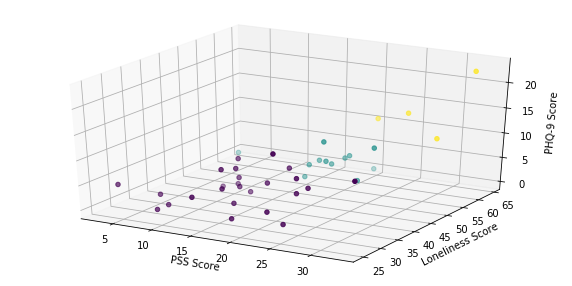

In [33]:
from mpl_toolkits.mplot3d import Axes3D
def cluster_3d_plot(data):
    x= data['pss score']
    y = data['loneliness score']
    z = data['phq score']
    cluster=data['cluster']
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=cluster, marker='o')

    ax.set_xlabel('PSS Score')
    ax.set_ylabel('Loneliness Score')
    ax.set_zlabel('PHQ-9 Score')

    plt.show()
cluster_3d_plot(surv)

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
def kmeans_clustering(uid_list, n_clusters): 
    """
    inputs: compiled_features containing survey scores and sensor rankings. 
    
    this function performs agglomerative clustering with 4 groups. 
    """    
    pss = pd.read_csv("dataset/dataset/survey/PerceivedStressScale.csv", index_col=0)
    prepss, postpss = pss_analysis(pss)

    loneliness = pd.read_csv("dataset/dataset/survey/LonelinessScale.csv", index_col=0)
    prelonely, postlonely = lonely_analysis(loneliness)

    phq = pd.read_csv("dataset/dataset/survey/PHQ-9.csv", index_col=0)
    pre_phq, post_phq = phq_analysis(phq)

    clustering = KMeans(n_clusters = n_clusters)
    
    survey_list = [(prepss, 'pss'), (prelonely, 'loneliness'), (pre_phq, 'phq')]
    
    survey_df = pd.DataFrame({'id':uid_list})
    
    for survey in survey_list:     
        survey_df = survey_df.merge(survey[0][['score', 'id']], on = 'id', how = 'inner')
        survey_df = survey_df.rename(columns = {'score': survey[1] + ' score'})
    
    scaler = StandardScaler()
    
    X = survey_df[['pss score', 'loneliness score', 'phq score']]
    X_scaled = scaler.fit_transform(X)
        
    #clustering.fit(survey_df[['pss score', 'loneliness score', 'phq score']])
    clustering.fit(X_scaled)
    
    survey_df['cluster'] = clustering.labels_
    
    return survey_df

In [29]:
results = kmeans_clustering(uids, 2)
results.head()

,id,pss score,loneliness score,phq score,cluster
0,u01,15.0,31,5,0
1,u02,21.0,32,13,1
2,u03,17.0,50,2,0
3,u04,21.0,54,6,1
4,u05,7.0,31,2,0


In [30]:
survey_df = agg_clustering(uids, 2)
survey_df.head()

,id,pss score,loneliness score,phq score,cluster
0,u01,15.0,31,5,1
1,u02,21.0,32,13,1
2,u03,17.0,50,2,0
3,u04,21.0,54,6,0
4,u05,7.0,31,2,1


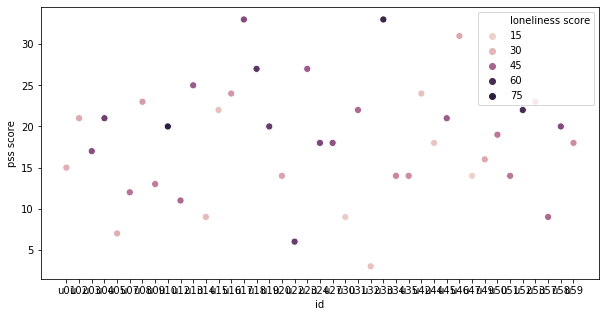

In [32]:
sns.scatterplot(x=survey_df.id, y=survey_df['pss score'], hue=survey_df['loneliness score'], s=50)
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [34]:
data = survey_df[['pss score', 'loneliness score', 'phq score']]

In [35]:
from sklearn.metrics import silhouette_score

def silhouette_score_analysis(data):
    sil = []
    cluster = []
    max_clusters = 10
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for i in range(2, max_clusters+1):
        """
        if ac == True:
            agg = AgglomerativeClustering(n_clusters = i).fit(data)
            labels = agg.labels_
            sil.append(silhouette_score(data, labels, metric = 'euclidean'))
            cluster.append(i)
        """
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        #kmeans = KMeans(n_clusters = i).fit(data_scaled)
        agg = AgglomerativeClustering(n_clusters = i).fit(data_scaled)
        #labels = kmeans.labels_
        labels = agg.labels_
        sil.append(silhouette_score(data_scaled, labels, metric = 'euclidean'))
        cluster.append(i)
    
    sil_df = pd.DataFrame({'clusters': cluster, 'score': sil})
    
    plt.plot(range(2, max_clusters+1), sil)
    plt.ylabel("Silhouette Score")
    plt.xlabel("Number of Clusters")
    plt.title("Silhouette Score by Number of Clusters")
    
    return sil_df

,clusters,score
0,2,0.404463
1,3,0.278001
2,4,0.305059
3,5,0.279305
4,6,0.319865
5,7,0.317685
6,8,0.313068
7,9,0.312325
8,10,0.314214


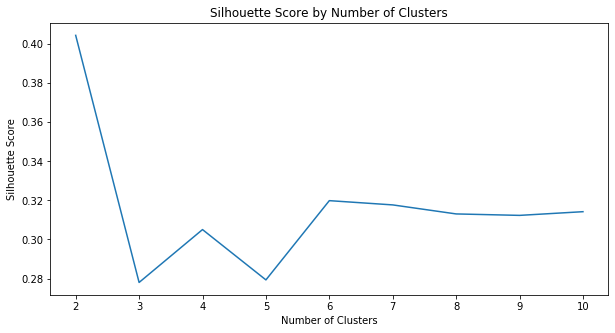

In [36]:
silhouette_score_analysis(results[['pss score', 'loneliness score', 'phq score']])

In [37]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [38]:
from sklearn.mixture import GaussianMixture
def gaussian_analysis(data):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    gm_bic= []
    gm_score=[]
    def process_gaussian(x):
        for i in range(2,12):
            gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(x)
            print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(x)))
            print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(x)))
            print("-"*100)
            gm_bic.append(gm.bic(x))
            gm_score.append(gm.score(x))
            
    process_gaussian(X_scaled)
    plt.figure(figsize=(7,4))
    plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
    plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
    plt.xticks([i for i in range(2,12)],fontsize=14)
    plt.yticks(fontsize=15)
    plt.show()

    
    '''
    gmm = GaussianMixture(n_components=7).fit(data)
    labels = gmm.predict(data)
    plt.scatter(data.iloc[:, 2], data.iloc[:, 0], c=labels, s = data.iloc[:, 1], cmap='viridis')
    '''
    
    return gm_bic, gm_score

BIC for number of cluster(s) 2: 368.92819344818895
Log-likelihood score for number of cluster(s) 2: -3.638662490009843
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 3: 377.351342737765
Log-likelihood score for number of cluster(s) 3: -3.288509180528537
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 4: 386.307757343297
Log-likelihood score for number of cluster(s) 4: -2.9448591066076704
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 5: 365.5484930022087
Log-likelihood score for number of cluster(s) 5: -2.238822704069483
----------------------------------------------------------------------------------------------------
BIC for number of cluster(s) 6: 381.38183033502264
Log-likelihood score for number of cluster(s) 6: -1.979037541456933
-----

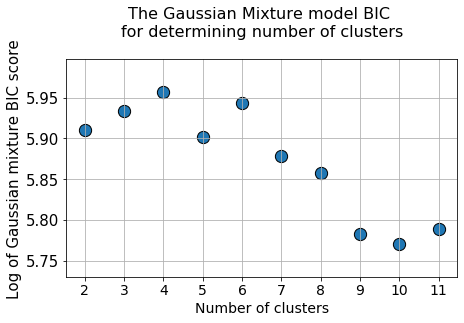

([368.92819344818895,
  377.351342737765,
  386.307757343297,
  365.5484930022087,
  381.38183033502264,
  357.0965008595224,
  349.964456431242,
  324.51481983729735,
  320.6346298197153,
  326.3876541220129],
 [-3.638662490009843,
  -3.288509180528537,
  -2.9448591066076704,
  -2.238822704069483,
  -1.979037541456933,
  -1.2300003445966479,
  -0.6901495507512402,
  0.07308651340714713,
  0.5732805461464775,
  0.9559963554726414])

In [39]:
gaussian_analysis(survey_df[['pss score', 'loneliness score', 'phq score']])

In [40]:
def draw_ellipse(position, covariance, kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax=False
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width = 2 * np.sqrt(covariance)
        height = width
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height,
                             angle, kwargs))

In [41]:
from matplotlib.patches import Ellipse
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
def gmm_cluster_analysis(data):
    """
    To find optimal number of clusters, we will perform a BIC and silhouette analysis on our data
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    #Silhouette analysis
    def silhouette_gmm(x):
        n_clusters = range(2, 12)
        sils=[]
        sils_err=[]
        iterations=20
        for n in n_clusters:
            tmp_sil=[]
            for i in range(iterations):
                gmm=GaussianMixture(n, n_init=2).fit(x) 
                labels=gmm.predict(x)
                sil=silhouette_score(x, labels, metric='euclidean')
                tmp_sil.append(sil)
            val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
            err=np.std(tmp_sil)
            sils.append(val)
            sils_err.append(err)
        return sils, sils_err
    
    sils, sils_err = silhouette_gmm(X_scaled)
    plt.errorbar(range(2,12), sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(range(2,12))
    plt.xlabel("Number of clusters")
    plt.ylabel("Score")
    plt.show()
    
    #BIC score analysis
    def BIC_gmm(x):
        n_clusters= range(2, 12)
        bics=[]
        bics_err=[]
        iterations=20
        for n in n_clusters:
            tmp_bic=[]
            for i in range(iterations):
                gmm=GaussianMixture(n, n_init=2).fit(x) 
                #gmm=GaussianMixture(n_components = n).fit(x) 
                tmp_bic.append(gmm.bic(x))
            val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
            err=np.std(tmp_bic)
            bics.append(val)
            bics_err.append(err)
        return bics, bics_err, gmm
    
    bics, bics_err, gmm = BIC_gmm(X_scaled)
    
    plt.errorbar(range(2,12), bics, yerr = bics_err, label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(range(2,12))
    plt.xlabel("Number of clusters")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
    plt.errorbar(range(2,12), np.gradient(bics), yerr=bics_err, label='BIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(range(2,12))
    plt.xlabel("Number of clusters")
    plt.ylabel("grad(BIC)")
    plt.legend()
    plt.show()
    
    #if plot is True:

    #def plot_GMM(x, ax=None, label=True):
 
    def plot_results(X, Y_, means, covariances, index, title):
        splot = plt.subplot(2, 1, 1 + index)
        for i, (mean, covar, color) in enumerate(zip(
                means, covariances, color_iter)):
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            # as the DP will not use every component it has access to
            # unless it needs it, we shouldn't plot the redundant
            # components.
            if not np.any(Y_ == i):
                continue
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.5)
            splot.add_artist(ell)

        plt.xlim(-3., 3.)
        plt.ylim(-2., 4.)
        plt.xticks(range(-3,4))
        plt.yticks(range(-2, 4))
        plt.title(title)
        
    
    
    gmm = GaussianMixture(n_components=5, covariance_type='full').fit(X_scaled)
    labels = gmm.predict(X_scaled)
    plot_results(X_scaled, gmm.predict(X_scaled), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')
    return labels

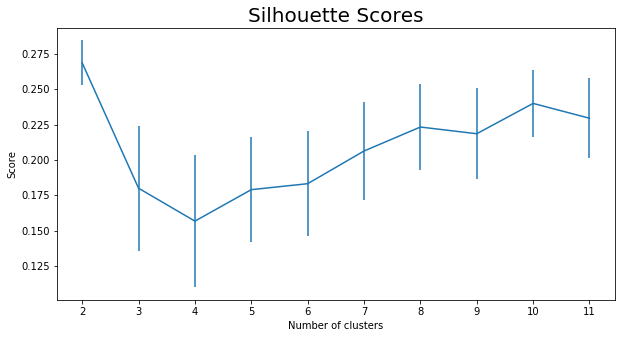

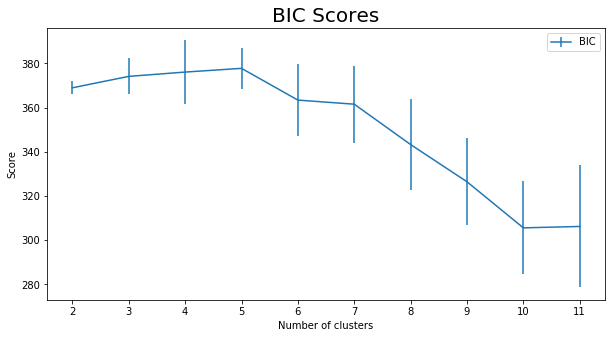

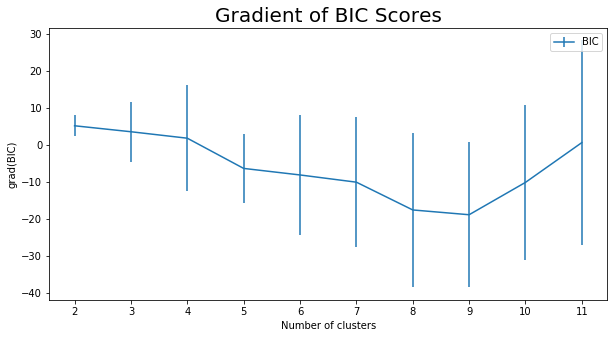

array([2, 2, 0, 1, 0, 2, 4, 2, 0, 0, 1, 0, 4, 4, 3, 3, 1, 2, 1, 3, 1, 1,
       0, 2, 0, 3, 2, 2, 4, 4, 3, 3, 2, 4, 2, 0, 3, 2, 0, 1, 4])

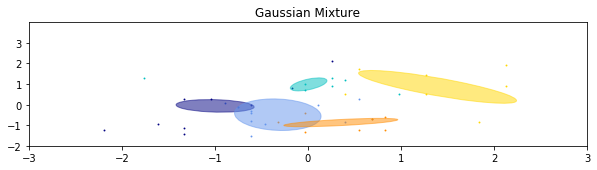

In [42]:
gmm_cluster_analysis(survey_df[['pss score', 'loneliness score', 'phq score']].values)

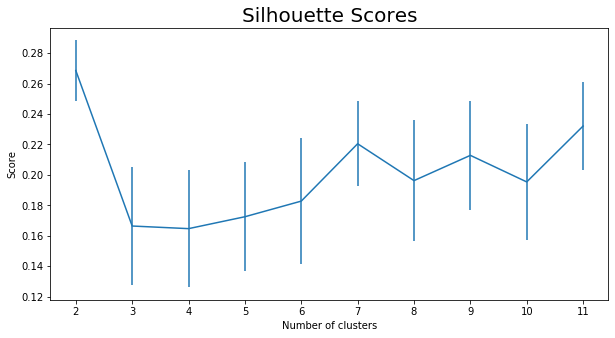

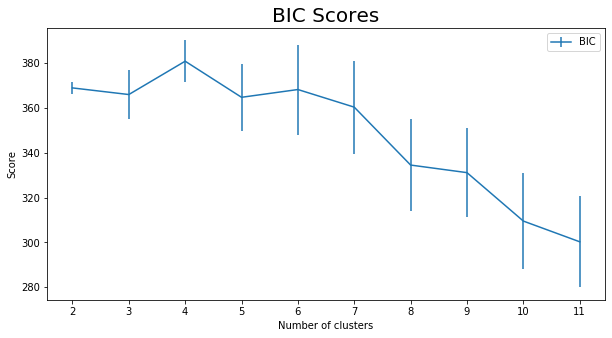

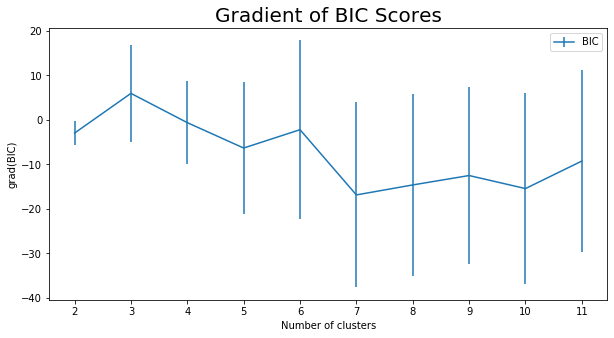

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


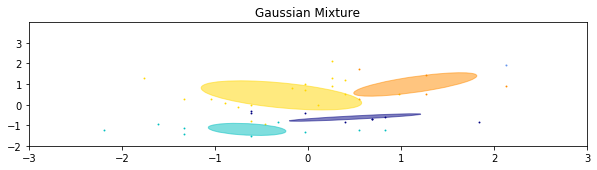

In [43]:
cluster_s = gmm_cluster_analysis(survey_df[['pss score', 'loneliness score', 'phq score']].values)

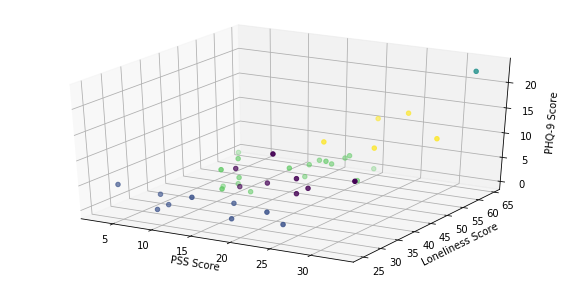

In [44]:
def gaussian_plot(data, labels):
    x= data['pss score']
    y = data['loneliness score']
    z = data['phq score']
    cluster=data['cluster']
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=labels, marker='o')

    ax.set_xlabel('PSS Score')
    ax.set_ylabel('Loneliness Score')
    ax.set_zlabel('PHQ-9 Score')

    plt.show()
gaussian_plot(surv, cluster_s)

In [45]:
def new_tscv_smote(features, target, model):
    """
    inputs: features -- numpy array of features
            target -- numpy array of targets with each target corresponding to one row of features
            model -- the machine learning model to predict with

    outputs: a tuple containing  time series cross validation score of the model predicting features and target
    along with a confusion matrix of predictions 
    """
    
    tscv = TimeSeriesSplit(n_splits = 5)
    avg_score = 0
    
    labels = []
    predictions = []
    
        
    for train_index, test_index in tscv.split(features): 
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
        
        sm = SMOTE(sampling_strategy='not majority', k_neighbors=2, random_state = 0)
        X_new_train, y_new_train = sm.fit_resample(X_train, y_train)
       
        model.fit(X_new_train, y_new_train)
        score = model.score(X_test, y_test)
        #print("train indices: {}, test indices: {}, score: {:.2f}".format(train_index, test_index, score))
        #print("predictions: {}, actual: {}".format(model.predict(X_test), target[test_index]))
        avg_score += score/5
        
        y_pred = model.predict(X_test)
        
        labels.extend(y_test)
        predictions.extend(y_pred)
        
        x = confusion_matrix(labels, predictions, labels=[1,2,3,4])


    ### turning the confusion matrix into dataframe df. 
    
    df = pd.DataFrame()
    for i in range(x.shape[0]): 
        if i == 0: 
            df = pd.DataFrame({i+1: x[:,i]})
        else: 
            df = df.join(pd.DataFrame({i+1: x[:,i]}))
    df.index = [1, 2, 3, 4]
            
    return avg_score, X_new_train, X_test, y_new_train, y_test

In [46]:
def evaluate_all_models(features, target):
    
    scaler = StandardScaler()

    # scale the data to mean 0 and variance 1
    scaled_features = scaler.fit_transform(features)
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    df = pd.DataFrame()
    
    for index in range(len(classifiers)): 
        print(names[index])
        df = df.append(pd.DataFrame({'name': names[index], 
                               'score': [tscv_smote(scaled_features, target, classifiers[index])[0]]}), ignore_index = True)
   
    #for i in range(len(classifiers)):
    train_data, test_data = new_tscv_smote(scaled_features, target, classifiers[0])[1], new_tscv_smote(scaled_features, target, classifiers[0])[2]
    train_ydata, test_ydata = new_tscv_smote(scaled_features, target, classifiers[0])[3], new_tscv_smote(scaled_features, target, classifiers[0])[4]

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(len(classifiers) + 1)
    #if ds_cnt == 0:
        #ax.set_title("Input data")
    # Plot the training points
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_ydata, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_ydata, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    plt.show()

    return df

Nearest Neighbors
Linear SVM
RBF SVM
Gaussian Process
Decision Tree
Random Forest
Neural Net
AdaBoost
Naive Bayes
QDA


/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


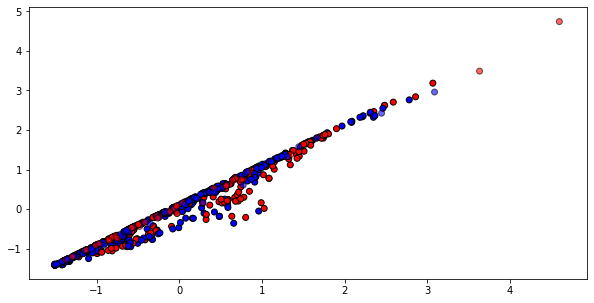

,name,score
0,Nearest Neighbors,0.266667
1,Linear SVM,0.255072
2,RBF SVM,0.431884
3,Gaussian Process,0.231884
4,Decision Tree,0.266667
5,Random Forest,0.310145
6,Neural Net,0.315942
7,AdaBoost,0.315942
8,Naive Bayes,0.208696
9,QDA,0.359420


In [47]:
evaluate_all_models(n[feature_names_].values, 
                                          n['picture_idx'].values)

In [48]:
def classifier_comparison(features, target):
    scaler = StandardScaler()
    h = 0.2
    # scale the data to mean 0 and variance 1
    scaled_features = scaler.fit_transform(features)
    x_min, x_max = scaled_features.min() - .5, scaled_features.max() + .5
    #x_min, x_max = scaled_features[:, 0].min() - .5, scaled_features[:, 0].max() + .5
    y_min, y_max = target.min() - .5, target.max() + .5
    #y_min, y_max = scaled_features[:, 1].min() - .5, scaled_features[:, 1].max() + .5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    #train_data, test_data = new_tscv_smote(scaled_features, target, classifiers[0])[1], new_tscv_smote(scaled_features, target, classifiers[0])[2]
    #train_ydata, test_ydata = new_tscv_smote(scaled_features, target, classifiers[0])[3], new_tscv_smote(scaled_features, target, classifiers[0])[4]
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        MLPClassifier(alpha=1, max_iter=1000),
        AdaBoostClassifier(),
        GaussianNB(),
        QuadraticDiscriminantAnalysis()]
    
    
    train_data, test_data = new_tscv_smote(scaled_features, target, classifiers[0])[1], new_tscv_smote(scaled_features, target, classifiers[0])[2]
    train_ydata, test_ydata = new_tscv_smote(scaled_features, target, classifiers[0])[3], new_tscv_smote(scaled_features, target, classifiers[0])[4]
    
    i = 1
    for name, model in zip(names, classifiers):
        ax = plt.subplot(len(features), len(classifiers) + 1, i)
        model.fit(train_data, train_ydata)
        score = model.score(test_data, test_ydata)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(model, "decision_function"):
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        plt.scatter(train_data[:, 0], train_data[:, 1], c=train_ydata, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        plt.scatter(test_data[:, 0], test_data[:, 1], c=test_ydata, cmap=cm_bright, alpha=0.6,
                   edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i+=1
    plt.show()

In [49]:
#classifier_comparison(n[feature_names_].values, n['picture_idx'].values)

In [50]:
#train_data, test_data = new_tscv_smote(scaled_features, target, classifiers[0])[1], new_tscv_smote(scaled_features, target, classifiers[0])[2]
#train_ydata, test_ydata = new_tscv_smote(scaled_features, target, classifiers[0])[3], new_tscv_smote(scaled_features, target, classifiers[0])[4]
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(n[feature_names_].values)
#scaled_features.shape[1]

In [51]:
#h=0.2
#x_min, x_max = scaled_features[:, 0].min() - .5, scaled_features[:, 0].max() + .5
#y_min, y_max = scaled_features[:, 1].min() - .5, scaled_features[:, 1].max() + .5
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                     np.arange(y_min, y_max, h))
#xx.shape[1]

In [52]:
#model = KNeighborsClassifier(3)
#model.fit()
#Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

In [134]:
def recursive_feature_selection(features, target, plot, only_imp, feature_names):
    X = features
    y = target

    #rfc = RandomForestClassifier(n_estimators = 500)
    svc = SVC(kernel="linear", C=0.025)
    #rfc = RandomForestClassifier(max_depth=5, n_estimators=500, max_features=1)
    rfc = RandomForestClassifier(max_depth=10, n_estimators=100)
    #RandomForestClassifier(random_state=101)
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(X, y) 
    
    #print('Optimal number of features: {}'.format(rfecv.n_features_))
    
    if plot is True:
        plt.figure(figsize=(16, 9))
        plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
        plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
        plt.ylabel('Cross Validation Score', fontsize=14, labelpad=20)
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

        plt.show()
      
    
    least_imp = np.where(rfecv.support_ == False)[0]
    
    
    if only_imp is True:
        z = X.columns[np.where(rfecv.support_ == False)[0]]
        X = X.drop(z, axis=1, inplace=True)
        dset = pd.DataFrame()
        dset['attr'] = X.columns
        dset['importance'] = rfecv.estimator_.feature_importances_

        dset = dset.sort_values(by='importance', ascending=False)


        plt.figure(figsize=(16, 14))
        plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
        plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
        plt.xlabel('Importance', fontsize=14, labelpad=20)
        plt.show()
    
    
    #least_imp
    '''
    def least_imp(list1):
        new_list = []
        for i in least_imp:
            new_list.append(feature_names[i])
        return new_list
    
    least_imp_feat = least_imp(list(least_imp))
    feat_names = feature_names
    
    for i in least_imp_feat:
        feat_names = feat_names.remove(i)
    '''
    
    return least_imp

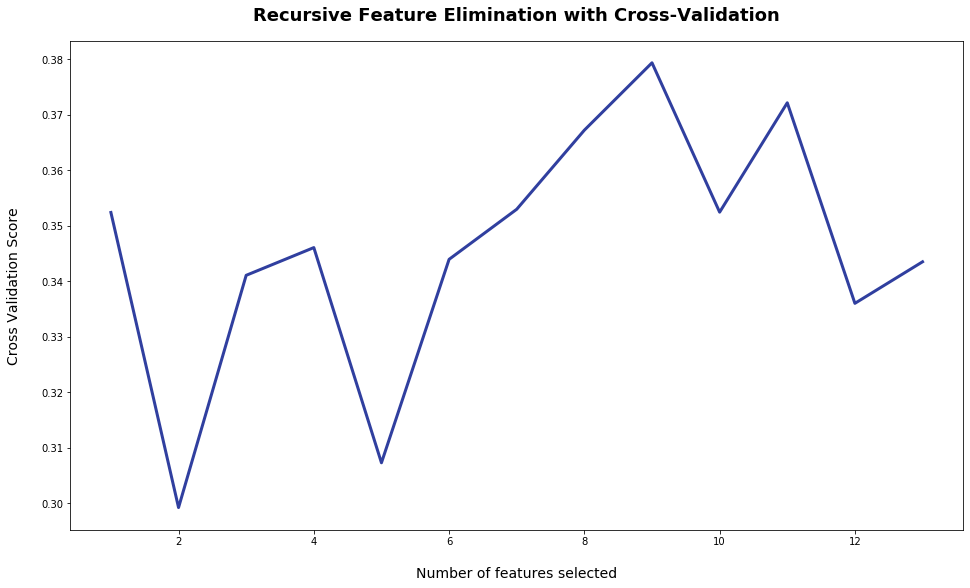

array([ 1,  2,  9, 12])

In [135]:
recursive_feature_selection(n[feature_names_], 
                                          n['picture_idx'], True, False, feature_names_)

In [56]:
def evaluate_performance_rfscv(features, target):
    num_features = []
    for i in range(0,10):
        num_features.append(recursive_feature_selection(features, target, False, False))
    return num_features

In [57]:
evaluate_performance_rfscv(n[feature_names_], 
                                          n['picture_idx'])

Optimal number of features: 10
Optimal number of features: 11
Optimal number of features: 11
Optimal number of features: 10
Optimal number of features: 6
Optimal number of features: 11
Optimal number of features: 8
Optimal number of features: 6
Optimal number of features: 7
Optimal number of features: 11


[array([ 2,  9, 12]),
 array([ 9, 12]),
 array([ 9, 12]),
 array([ 0,  9, 12]),
 array([ 0,  2,  3,  6,  9, 10, 12]),
 array([ 9, 12]),
 array([ 0,  2,  3,  9, 12]),
 array([ 0,  1,  2,  3,  6,  9, 12]),
 array([ 0,  2,  3,  6,  9, 12]),
 array([ 9, 12])]

In [109]:
from sklearn.linear_model import LinearRegression
def backward_elimination(data, features, target):
    X = features
    y = target

    svc = SVC(kernel="linear", C=0.025)
    #rfc = RandomForestClassifier(max_depth=5, n_estimators=500)
    rfc = LinearRegression()
    
    pmax = 1
    while (len(X)>0):
        p= []
        X_1 = data[X]
        y_1 = data[y]
        model = rfc.fit(X_1, y_1)
        p = pd.Series(model.pvalues.values[1:],index = X)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            X.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = X
    #print(selected_features_BE)
    
    return selected_features_BE

In [110]:
#backward_elimination(n, feature_names_, 'picture_idx')
#tpot??

In [128]:
def sfs_selection(data, features, target, plot, accuracy, cv):
    X = features
    y = target
    
    X_1 = data[X]
    y_1 = data[y]
    #X_1 = X
    #y_1 = y
    x_train, x_test, y_train, y_test = train_test_split(X_1, y_1)
    
    if accuracy is True:
        if cv is True:
            sfs1 = SFS(RandomForestClassifier(max_depth=10, n_estimators=100),
                k_features= (1,13), 
                forward=True,
                floating=False,
                scoring='accuracy',
                cv=5)
        else: 
            sfs1 = SFS(RandomForestClassifier(max_depth=10, n_estimators=100),
                k_features= (1,13), 
                forward=True,
                floating=False,
                scoring='accuracy',
                cv=0)
            
    sfs1.fit(X_1, y_1)
    
    df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
    
    if plot is True:
        fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')
        plt.title('Sequential Forward Selection (w. StdDev)')
        plt.grid()
        plt.show()
    
    return len(sfs1.k_feature_names_)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


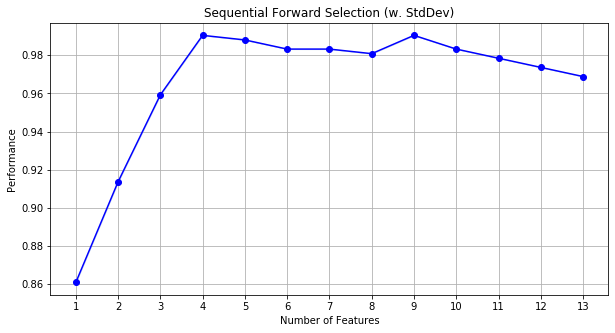

4

In [129]:
sfs_selection(n, feature_names_, 'picture_idx', True, True, False)

In [121]:
def evaluate_performance_cv(data, features, target):
    num_features = []
    for i in range(0,10):
        num_features.append(sfs_selection(data, features, target, False, True, True))
    return num_features

In [122]:
def evaluate_performance_acc(data, features, target):
    num_features = []
    for i in range(0,10):
        num_features.append(sfs_selection(data, features, target, False, True, False))
    return num_features

In [252]:
evaluate_performance_cv(n, feature_names_, 'picture_idx')

[9, 9, 8, 1, 1, 1, 6, 6, 1, 1]

In [124]:
evaluate_performance_acc(n, feature_names_, 'picture_idx')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217:

[9, 4, 4, 4, 5, 5, 5, 4, 4, 6]

In [256]:
feature_names_[3]

'academic location dur'